In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# Any results you write to the current directory are saved as output.

/kaggle/input/ifood-2019-fgvc6/test_set.zip
/kaggle/input/ifood-2019-fgvc6/train_labels.csv
/kaggle/input/ifood-2019-fgvc6/ifood2019_sample_submission.csv
/kaggle/input/ifood-2019-fgvc6/val_set.zip
/kaggle/input/ifood-2019-fgvc6/train_set.zip
/kaggle/input/ifood-2019-fgvc6/val_labels.csv
/kaggle/input/ifood-2019-fgvc6/sample_submission.csv
/kaggle/input/ifood-2019-fgvc6/class_list.txt


In [2]:
from zipfile import ZipFile
import shutil

if not os.path.exists("./train_set"):
    for file_name in ['train_set.zip', 'val_set.zip', 'test_set.zip']:
        with ZipFile('../input/ifood-2019-fgvc6/' + file_name, 'r') as zipObj:
            print("unzipping", file_name)
            zipObj.extractall('./')

for dirname, _, _ in os.walk('./'):
    print(dirname)

unzipping train_set.zip
unzipping val_set.zip
unzipping test_set.zip
./
./test_set
./val_set
./train_set


In [3]:
df_train = pd.read_csv('../input/ifood-2019-fgvc6/train_labels.csv')
df_val   = pd.read_csv('../input/ifood-2019-fgvc6/val_labels.csv')
df_test = pd.read_csv('../input/ifood-2019-fgvc6/sample_submission.csv')

df_train['label'] = df_train['label'].astype(str)
df_val['label'] = df_val['label'].astype(str)

train_size = df_train.shape[0]
val_size = df_val.shape[0]
test_size = df_test.shape[0]

# Number of classes in the dataset
num_classes = df_train['label'].nunique()

In [4]:
for ind, item in df_train.iterrows():
    if not os.path.exists("./train_set/" + item['label']):
        os.mkdir("./train_set/" + item['label'])
    os.rename("./train_set/"+item['img_name'], "./train_set/"+item['label']+"/"+item['img_name'])
    
for ind, item in df_val.iterrows():
    if not os.path.exists("./val_set/" + item['label']):
        os.mkdir("./val_set/" + item['label'])
    os.rename("./val_set/"+item['img_name'], "./val_set/"+item['label']+"/"+item['img_name'])

os.mkdir("./test_set/0")
for ind, item in df_test.iterrows():
    os.rename("./test_set/"+item['img_name'], "./test_set/0/"+item['img_name'])

In [5]:
# from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
print(models.__dict__.keys())
model_name = "densenet161"

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs to train for
num_epochs = 20

# When feature_extract=False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

PyTorch Version:  1.4.0
Torchvision Version:  0.5.0
dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__path__', '__file__', '__cached__', '__builtins__', 'utils', 'alexnet', 'AlexNet', 'resnet', 'ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnext50_32x4d', 'resnext101_32x8d', 'wide_resnet50_2', 'wide_resnet101_2', 'vgg', 'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'squeezenet', 'SqueezeNet', 'squeezenet1_0', 'squeezenet1_1', 'inception', 'Inception3', 'inception_v3', 'InceptionOutputs', '_InceptionOutputs', 'densenet', 'DenseNet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'googlenet', 'GoogLeNet', 'GoogLeNetOutputs', '_GoogLeNetOutputs', 'mobilenet', 'MobileNetV2', 'mobilenet_v2', 'mnasnet', 'MNASNet', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'shufflenetv2', 'ShuffleNetV2', 'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 'shufflenet_v2_x1_5', 'shufflenet_

In [6]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [7]:
def initialize_model(model_name, num_classes, feature_extract=True, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = models.__dict__[model_name](pretrained=use_pretrained)
    input_size = 0

    if model_name in ["resnet18", "resnet101", "resnext101_32x8d"]:
        """ Resnet
        """
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name in ["densenet", "densenet161"]:
        """ Densenet
        """
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name in ["inception", "inception_v3"]:
        """ Inception
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract=feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth



DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

In [8]:
import time
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler

NUM_TRAIN = 1000
NUM_VAL = 100

transform_train = T.Compose([
    T.RandomResizedCrop(input_size),
    T.RandomHorizontalFlip(),
    T.RandomRotation(360),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = T.Compose([
    T.Resize(input_size),
    T.CenterCrop(input_size),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_train = torchvision.datasets.ImageFolder(
                root="./train_set",
                transform=transform_train
            )
# loader_train = DataLoader(data_train, batch_size=batch_size, pin_memory=True,
#                           sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
loader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True, pin_memory=True)
data_val = torchvision.datasets.ImageFolder(
                root="./val_set",
                transform=transform_test
            )
# loader_val = DataLoader(data_val, batch_size=batch_size, pin_memory=True,
#                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))
loader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False, pin_memory=True)
data_test = torchvision.datasets.ImageFolder(
                root="./test_set",
                transform=transform_test
            )
loader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False, pin_memory=True)

dataloaders_dict = {'train': loader_train, 'val': loader_val, 'test': loader_test}

In [9]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [10]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()
    
    train_history = []
    val_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'train':
                train_history.append({'loss': epoch_loss, 'acc': epoch_acc})
            if phase == 'val':
                val_history.append({'loss': epoch_loss, 'acc': epoch_acc})
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), model_name+'.pth.tar')
    return model, train_history, val_history

In [11]:
def predict(loader, model):
    model.eval()
    y_pred = torch.tensor([], dtype=torch.long, device=device)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
#             _, preds = scores.max(1)
            # top-3 prediction
            _, preds = torch.topk(scores, k=3, dim=1)
            y_pred = torch.cat((y_pred, preds), 0)
        return y_pred

In [12]:
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
learning_rate = 1e-3
# optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
optimizer_ft = torch.optim.Adam(params_to_update, lr=learning_rate)

Params to learn:
	 classifier.weight
	 classifier.bias


In [13]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, train_hist, val_hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, 
                                             num_epochs=num_epochs, is_inception=(model_name=="inception_v3"))

Epoch 0/19
----------
train Loss: 3.9794 Acc: 0.2002
val Loss: 2.9302 Acc: 0.3441

Epoch 1/19
----------
train Loss: 3.4546 Acc: 0.2770
val Loss: 2.7193 Acc: 0.3879

Epoch 2/19
----------
train Loss: 3.3636 Acc: 0.2949
val Loss: 2.6611 Acc: 0.3921

Epoch 3/19
----------
train Loss: 3.3090 Acc: 0.3037
val Loss: 2.6282 Acc: 0.4042

Epoch 4/19
----------
train Loss: 3.2799 Acc: 0.3101
val Loss: 2.5929 Acc: 0.4032

Epoch 5/19
----------
train Loss: 3.2701 Acc: 0.3106
val Loss: 2.5835 Acc: 0.4080

Epoch 6/19
----------
train Loss: 3.2435 Acc: 0.3155
val Loss: 2.5624 Acc: 0.4118

Epoch 7/19
----------
train Loss: 3.2408 Acc: 0.3160
val Loss: 2.5114 Acc: 0.4217

Epoch 8/19
----------
train Loss: 3.2356 Acc: 0.3188
val Loss: 2.5984 Acc: 0.4117

Epoch 9/19
----------
train Loss: 3.2245 Acc: 0.3200
val Loss: 2.5386 Acc: 0.4177

Epoch 10/19
----------
train Loss: 3.2219 Acc: 0.3211
val Loss: 2.6004 Acc: 0.4024

Epoch 11/19
----------
train Loss: 3.2166 Acc: 0.3216
val Loss: 2.5538 Acc: 0.4131

Ep

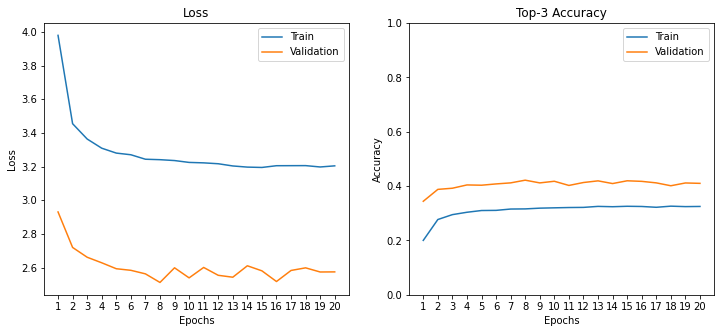

In [14]:
train_loss = [h['loss'] for h in train_hist]
train_acc = [h['acc'].cpu().numpy() for h in train_hist]
val_loss = [h['loss'] for h in val_hist]
val_acc = [h['acc'].cpu().numpy() for h in val_hist]

fig = plt.figure(figsize=(12, 5))
fig.add_subplot(1, 2, 1)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(1,num_epochs+1), train_loss, label="Train")
plt.plot(range(1,num_epochs+1), val_loss, label="Validation")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()

fig.add_subplot(1, 2, 2)
plt.title("Top-3 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,num_epochs+1), train_acc, label="Train")
plt.plot(range(1,num_epochs+1), val_acc, label="Validation")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [15]:
df_hist = pd.DataFrame({
    'train_loss': train_loss,
    'val_loss': val_loss,
    'train_acc': train_acc,
    'val_acc': val_acc
})
df_hist.to_csv("hist.csv")

In [16]:
y_pred = predict(loader_test, model_ft)
class_map = {v: int(k) for k,v in data_val.class_to_idx.items()}
y_pred_class = np.vectorize(class_map.get)(y_pred.cpu().numpy())
df_test = df_test.sort_values('img_name')
df_test['label'] = [' '.join(item) for item in y_pred_class.astype(str)]
df_test.to_csv("submission.csv", index=False)

In [17]:
for path in ["./train_set", "./val_set", "./test_set"]:
    shutil.rmtree(path)